## Crack segmentation on asphalt photos- DL

### Maria Musial 156062
### Martyna Stasiak 156071

In [102]:
import numpy as np 
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import h5py
import random

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt


## Loading data
We are reading paths and extracting binary information about existence of cracks from mask photos. 

In [78]:
np.random.seed(44)  #A imie jego czterdziesci i cztery...
tf.random.set_seed(44)

df = pd.DataFrame({
    "filepath": [],
    "label": []
})

images_directory = "./train/images"
masks_directory = "./train/masks"
images = []
labels = []
for img_name in os.listdir(images_directory):
    img_path = os.path.join(images_directory, img_name)
    
    mask_path = os.path.join(masks_directory, img_name)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    
    label = "1" if np.any(mask>0) else "0" 
    
    labels.append(label)
    df.loc[len(df)] = [img_path, label]
labels = np.array(labels)

#SPLITTING DATA FOR VALIDATION AND TRAINING
train_df, val_df = train_test_split(df, test_size=0.2, random_state=44, stratify=df["label"])

KeyboardInterrupt: 

-----------
## Data augumentation
**Rescale**- We rescale the image to values <0,1> <br>
**Shear range**- shear transfomation to simulate distortions <br>
**Zoom_range**- randomly zooms image 80% to 120% of its original size. for more variation<br>
**Rotation range-** rotation of image up to 1 degree. As we dont have only perfectly horizontal/vertical lines<br>
**Width shift range**- shifts the image horizontally by a fraction of its width<br>
**Horizontal flip**- true: randomly flips the image horizontally <br>
**Fill mode**- reflect to mirror edge pixels of the image to fill faps<br>
<br><br>
All those settings give simillar images and enough variety to have well augumented data.


No data augumentation for validation, as we need to validate data, but we need rescaling to <0,1>. 

In [3]:
# Define the data generator for augumentation

datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.01,      
    zoom_range=(0.8, 1.2),  
    rotation_range=5,   
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    brightness_range=(0.8, 0.9),
    fill_mode='reflect'
)

#Load images from dataframe
train_generator = datagen.flow_from_dataframe(
    dataframe = train_df,  
    x_col = "filepath",
    y_col = "label",
    target_size=(128, 128),  
    class_mode="binary",  
    batch_size=16,
    shuffle=True,
    seed=44
)

#Defining dynamic creation of validation data
val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_dataframe(
    dataframe = val_df,
    x_col = "filepath",
    y_col = "label",
    target_size = (128, 128),
    batch_size = 16,
    class_mode = 'binary'
)
validation_steps = len(val_generator)

Found 7682 validated image filenames belonging to 2 classes.
Found 1921 validated image filenames belonging to 2 classes.


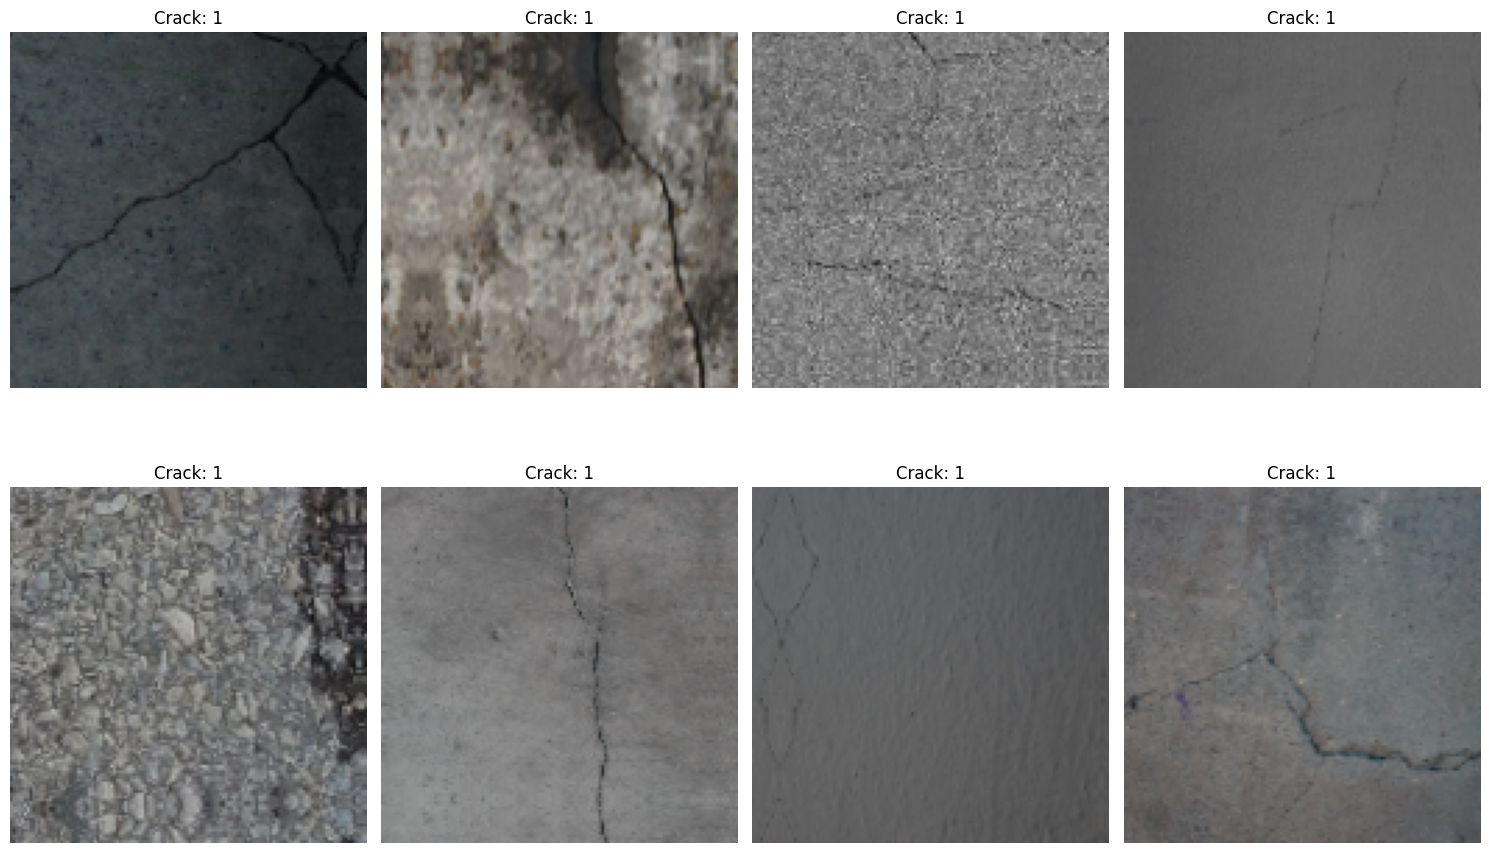

In [4]:
# Function to plot augmented images
def plot_augmented_images(generator, n_rows=2, n_cols=4):
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 10))
    axs = axs.flatten()  # Flatten the array of axes for easier indexing

    # Generate one batch of images and labels
    images, labels = next(generator)  

    # Iterate through the images and display them
    for i in range(len(axs)):
        if i < len(images):  # Ensure we don't go out of bounds
            img = images[i]
            img = (img * 255).astype(np.uint8)

            axs[i].imshow(img)
            axs[i].set_title(f"Crack: {int(labels[i])}")  # Convert label to int
            axs[i].axis('off')
        else:
            axs[i].axis('off')  

    plt.tight_layout()
    plt.show()

# Plot the augmented images
plot_augmented_images(train_generator)

---------
## Models - architecture selection

#### I also checked transfer learning from ResNet50 on other file, but it was computationally expensive and not worth the results.

### We are using keras_tuner to check for best architecture.

##### Get data for hyperparameter tuning. Only a subset for efficiency

In [12]:
# Load and preprocess images
def load_and_preprocess_image(image_path, target_size=(128, 128)):
    image = load_img(image_path, target_size=target_size)  # Load and resize image
    image = img_to_array(image) / 255.0  # Normalize pixel values
    return image

# Load the DataFrame
df_hyper = val_df.copy()

# Apply preprocessing to all images in the dataframe
df_hyper['image'] = df_hyper['filepath'].apply(load_and_preprocess_image)
X_val = np.array(df_hyper['image'].tolist())
y_val = df_hyper['label'].values.astype(int)

In [13]:
def build_model(hp):
    model = Sequential()
    model.add(Input((128, 128, 3)))
    # Input Layer
    model.add(
        Conv2D(
            filters=hp.Choice('filters_layer_0', values=[16, 32, 64]),
            kernel_size=(3, 3),
            activation='relu'
        )
    )
    model.add(MaxPooling2D((2, 2)))

    # Dynamically Adding Convolutional Layers
    for i in range(hp.Int('num_layers', min_value=2, max_value=5)):
        model.add(
            Conv2D(
                filters=hp.Choice(f'filters_layer_{i}', values=[16, 32, 64]),
                kernel_size=(3, 3),
                activation='relu',
                padding='same'
            )
        )
        model.add(MaxPooling2D((2, 2)))

        # Optional Batch Normalization
        if hp.Boolean(f'batch_norm_layer_{i}'):
            model.add(BatchNormalization())

    # Flatten for Dense Layers
    model.add(Flatten())

    # Dense Layers
    model.add(
        Dense(
            units=hp.Int('dense_units', min_value=32, max_value=128, step=32),
            activation='relu'
        )
    )

    # Optional Dropout
    if hp.Boolean('use_dropout'):
        model.add(Dropout(rate=hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)))

    # Output Layer
    model.add(Dense(1, activation='sigmoid'))

    # Compiling the Model
    learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3])
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy']
        # metrics=['accuracy', tf.keras.metrics.AUC(), 'precision', 'recall']
    )

    return model


In [14]:
tuner = kt.RandomSearch(
    build_model,
    max_trials=20,
    executions_per_trial=1,
    objective="val_accuracy",
    # max_epochs=20,
    # factor=3,  # Determines the reduction factor for successive trials in Hyperband. A higher factor reduces the number of trials but increases the focus on promising configurations.
    directory="tuning",
    project_name="hyperband_tuning"
)

Reloading Tuner from tuning\hyperband_tuning\tuner0.json


In [15]:
#not used, possibly more efficient
# tuner = kt.Hyperband(
#     build_model,
#     objective="val_accuracy",
#     max_epochs=20,
#     factor=3,  # Determines the reduction factor for successive trials in Hyperband. A higher factor reduces the number of trials but increases the focus on promising configurations.
#     directory="tuning",
#     project_name="hyperband_tuning",
# )

In [16]:
tuner.search_space_summary()


Search space summary
Default search space size: 9
filters_layer_0 (Choice)
{'default': 16, 'conditions': [], 'values': [16, 32, 64], 'ordered': True}
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 5, 'step': 1, 'sampling': 'linear'}
batch_norm_layer_0 (Boolean)
{'default': False, 'conditions': []}
filters_layer_1 (Choice)
{'default': 16, 'conditions': [], 'values': [16, 32, 64], 'ordered': True}
batch_norm_layer_1 (Boolean)
{'default': False, 'conditions': []}
dense_units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 32, 'sampling': 'linear'}
use_dropout (Boolean)
{'default': False, 'conditions': []}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}
dropout_rate (Float)
{'default': 0.2, 'conditions': [], 'min_value': 0.2, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}


We are using only validation data, so we're using only subset of data to determine best architecture. Its more computationally efficient, but tells us what we need to know about architectures

In [17]:
tuner.search(X_val, y_val, validation_split=0.2, epochs=10) 

Trial 20 Complete [00h 01m 12s]
val_accuracy: 0.9454545378684998

Best val_accuracy So Far: 0.948051929473877
Total elapsed time: 01h 06m 21s


### Best parameters

In [24]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"Best number of layers: {best_hps.get('num_layers')}")
print(f"Best filters for layer 0: {best_hps.get('filters_layer_0')}")
print(f"Best filters for other layers: {[best_hps.get(f'filters_layer_{i}') for i in range(best_hps.get('num_layers'))]}")
print(f"Best batch normalization: {[best_hps.get(f'batch_norm_layer_{i}') for i in range(best_hps.get('num_layers'))]}")
print(f"Best dense units: {best_hps.get('dense_units')}")
print(f"Use dropout: {best_hps.get('use_dropout')}")
if best_hps.get('use_dropout'):
    print(f"Dropout rate: {best_hps.get('dropout_rate')}")
print(f"Best learning rate: {best_hps.get('learning_rate')}")


Best number of layers: 5
Best filters for layer 0: 16
Best filters for other layers: [16, 32, 32, 16, 16]
Best batch normalization: [False, True, False, False, False]
Best dense units: 96
Use dropout: False
Best learning rate: 0.001


### Building and train the best model


In [ ]:
best_model = tuner.hypermodel.build(best_hps)
best_model.compile(
    optimizer=Adam(learning_rate=0.001),  # Adjust learning rate as needed
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(), 'precision', 'recall']
)
best_model.summary()


callbacks = [
    ModelCheckpoint('best_model_hyperparametered.keras', monitor='val_loss', save_best_only=True, mode='min'),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    TensorBoard(log_dir='logs')  # Logs for TensorBoard
]
history = best_model.fit(train_generator, validation_data=val_generator, epochs=50, callbacks=callbacks, verbose=1)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_11 (Conv2D)              │ (None, 126, 126, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 63, 63, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 63, 63, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 31, 31, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 31, 31, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 15, 15, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 15, 15, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 7, 7, 16)       │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 3, 3, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 3, 3, 16)       │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 1, 1, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 96)             │         1,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            97 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,457 (99.44 KB)

 Trainable params: 25,393 (99.19 KB)

 Non-trainable params: 64 (256.00 B)

Epoch 1/50
481/481 ━━━━━━━━━━━━━━━━━━━━ 65s 129ms/step - accuracy: 0.8780 - auc: 0.7907 - loss: 0.3180 - precision: 0.9007 - recall: 0.9609 - val_accuracy: 0.8714 - val_auc: 0.4807 - val_loss: 0.9205 - val_precision: 0.8714 - val_recall: 1.0000
Epoch 2/50
481/481 ━━━━━━━━━━━━━━━━━━━━ 53s 110ms/step - accuracy: 0.9207 - auc: 0.8923 - loss: 0.2225 - precision: 0.9416 - recall: 0.9695 - val_accuracy: 0.9115 - val_auc: 0.8947 - val_loss: 0.2585 - val_precision: 0.9547 - val_recall: 0.9432
Epoch 3/50
481/481 ━━━━━━━━━━━━━━━━━━━━ 49s 101ms/step - accuracy: 0.9378 - auc: 0.9170 - loss: 0.1908 - precision: 0.9501 - recall: 0.9805 - val_accuracy: 0.9204 - val_auc: 0.9202 - val_loss: 0.2152 - val_precision: 0.9568 - val_recall: 0.9516
Epoch 4/50
481/481 ━━━━━━━━━━━━━━━━━━━━ 51s 107ms/step - accuracy: 0.9429 - auc: 0.9248 - loss: 0.1769 - precision: 0.9508 - recall: 0.9856 - val_accuracy: 0.9328 - val_auc: 0.9240 - val_loss: 0.1981 - val_precision: 0.9612 - val_recall: 0.9618
Epoch 5/50
481/481 ━

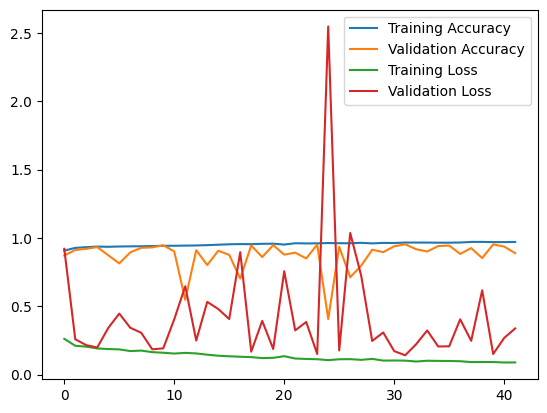

In [31]:
def plot_history(hist):
    plt.plot(hist.history['accuracy'], label='Training Accuracy')
    plt.plot(hist.history['val_accuracy'], label='Validation Accuracy')
    plt.plot(hist.history['loss'], label='Training Loss')
    plt.plot(hist.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.show()

plot_history(history)

-----------
## Evlauating the chosen architecture


In [32]:
test_df = pd.DataFrame({
    "filepath": [],
    "label": []
})

images_directory = "./test/images"
masks_directory = "./test/masks"
labels = []
for img_name in os.listdir(images_directory):
    img_path = os.path.join(images_directory, img_name)
    
    mask_path = os.path.join(masks_directory, img_name)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    
    label = "1" if np.any(mask>0) else "0" 
    
    labels.append(label)
    test_df.loc[len(test_df)] = [img_path, label]
labels = np.array(labels)

In [ ]:
#Defining new generator for test data
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col="filepath",
    y_col="label",
    target_size=(128, 128),
    batch_size=16,
    class_mode='binary',
    shuffle=False  # Keep order for reproducibility
)

Found 1695 validated image filenames belonging to 2 classes.


In [34]:
best_model.metrics

[<Mean name=loss>, <CompileMetrics name=compile_metrics>]

In [35]:
# Evaluate the model
test_loss, test_accuracy, test_auc, test_precision, test_recall = best_model.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test AUC: {test_auc:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")

C:\Users\mary9\AppData\Roaming\Python\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


106/106 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - accuracy: 0.9664 - auc: 0.5636 - loss: 0.0928 - precision: 0.9724 - recall: 0.9889
Test Loss: 0.1392
Test Accuracy: 0.9499
Test AUC: 0.9665
Test Precision: 0.9590
Test Recall: 0.9844


--------------
## Result analysis

In [ ]:
# Load the model
model = best_model  # Load your trained model here

correctly_classified_images = []
incorrectly_classified_images = []

predi=test_df.copy()

for index, row in predi.iterrows():
    image_path = row['filepath']
    true_label = row['label']
    
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    target_size = (128, 128)
    image_resized = cv2.resize(image, target_size)
    image_normalized = image_resized / 255.0
    image_input = np.expand_dims(image_normalized, axis=0)
    
    predictions = model.predict(image_input, verbose=0)
    predicted_label = (predictions > 0.5).astype(int)[0][0]
    # print(predicted_label, type(true_label), predicted_label == int(true_label))
    
    if predicted_label == int(true_label):
        correctly_classified_images.append([image, true_label, predicted_label, image_path])
    else:
        incorrectly_classified_images.append([image, true_label, predicted_label, image_path])
print(len(correctly_classified_images), len(incorrectly_classified_images))



1594 101


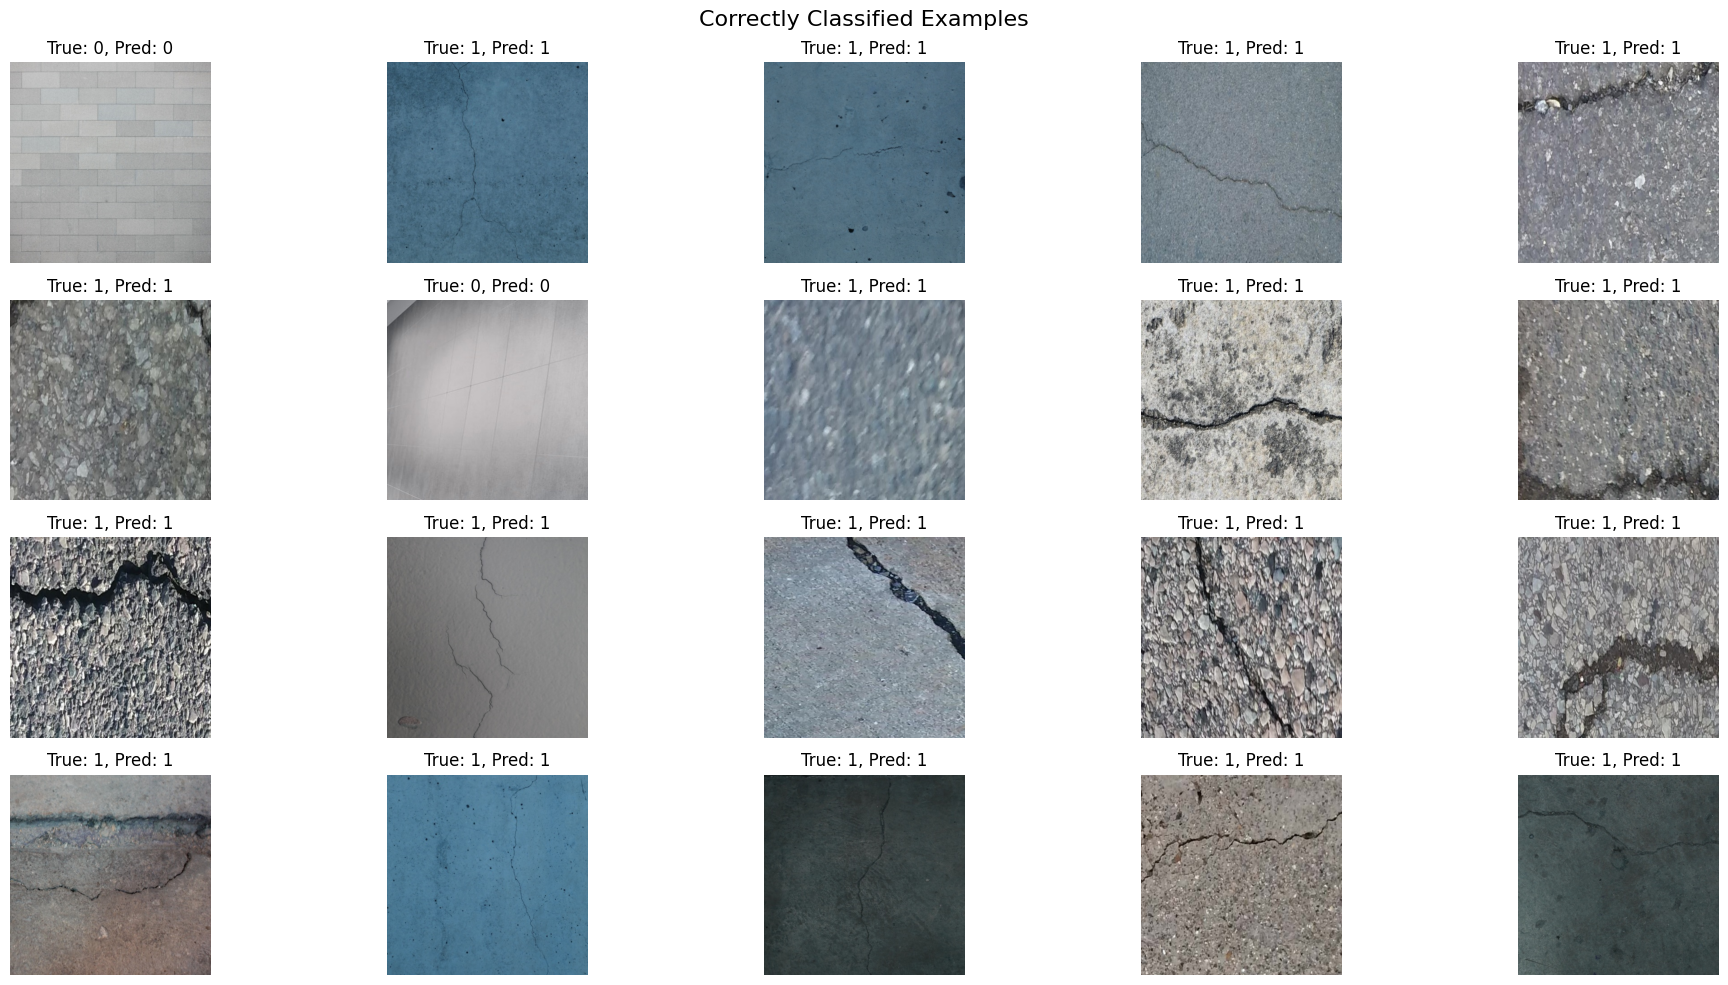

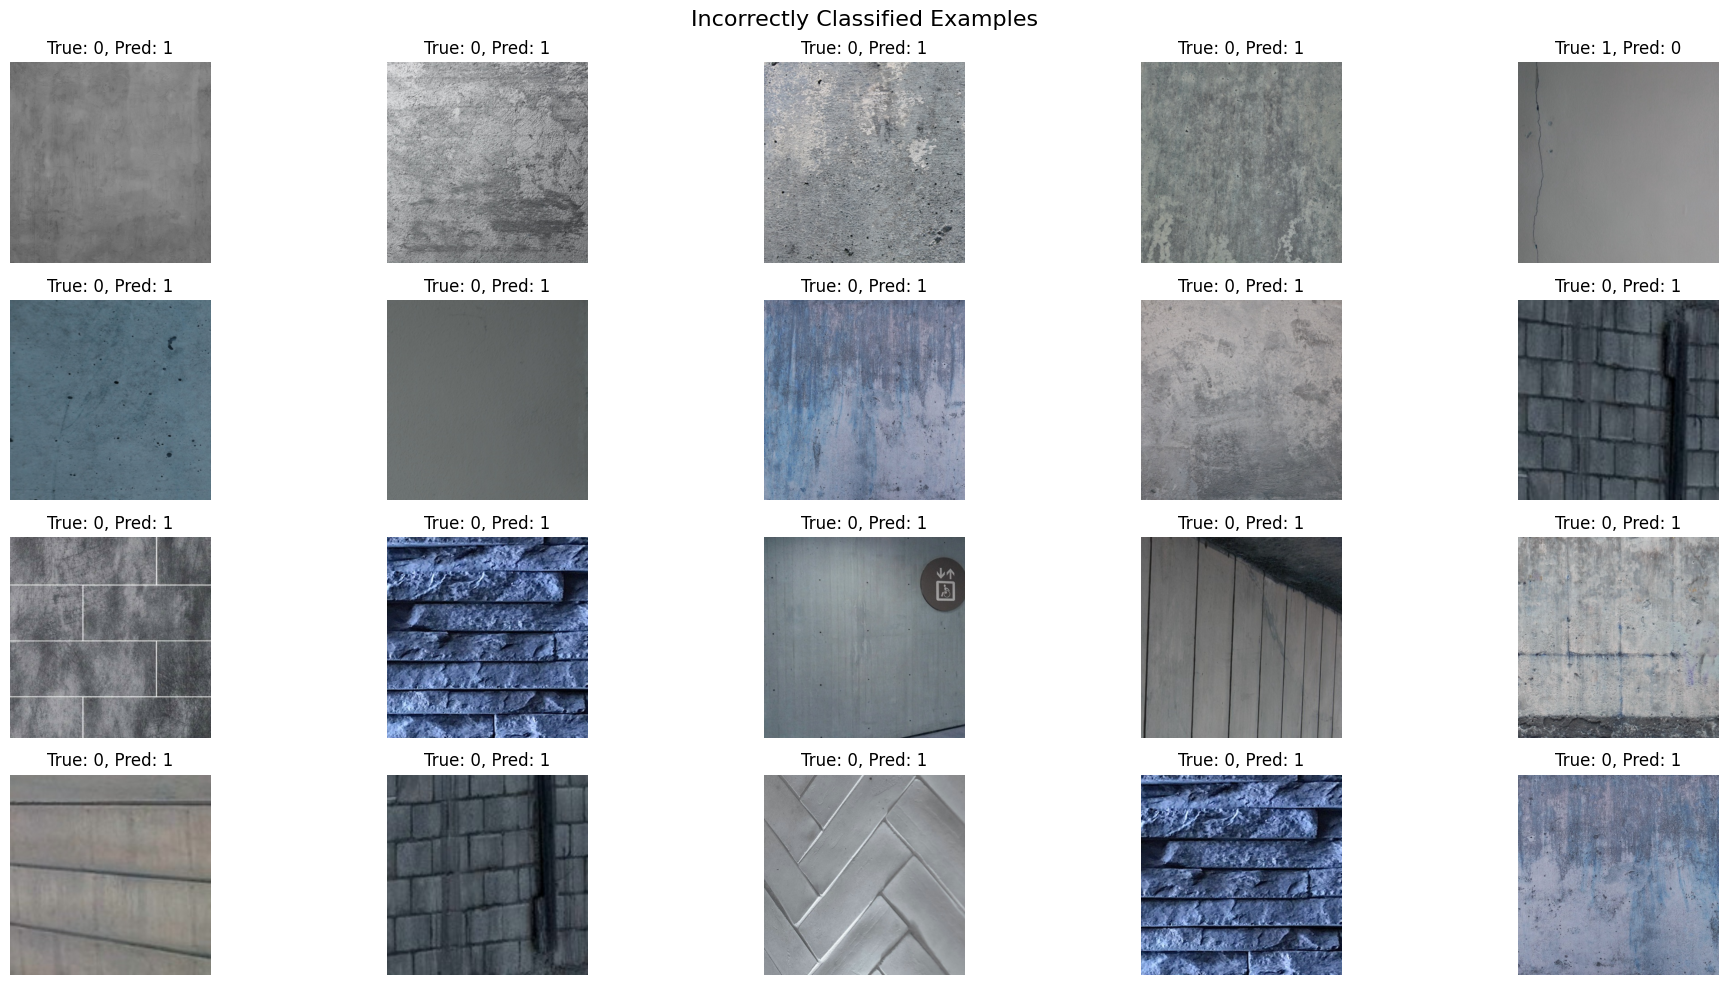

In [103]:
random.seed(44)
correctly_sample = random.sample(correctly_classified_images, min(20, len(correctly_classified_images)))
incorrectly_sample = random.sample(incorrectly_classified_images, min(20, len(incorrectly_classified_images)))

# Function to display images
def display_images(image_data, title):
    fig, axs = plt.subplots(4, 5, figsize=(20, 10))
    axs = axs.flatten()
    for i, (image, true_label, pred_label, image_path) in enumerate(image_data):
        img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        axs[i].imshow(img_rgb)
        axs[i].set_title(f"True: {true_label}, Pred: {pred_label}")
        axs[i].axis('off')
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

# Display the results
display_images(correctly_sample, "Correctly Classified Examples")
display_images(incorrectly_sample, "Incorrectly Classified Examples")

#### As we can see, the biggest problem is with tiles/ bricks. The pattern is simillar to cracks, as it is a ripple in texture. On the other side there is a problem with not detecting cracks in iamges that have heavy texture like the asphalt photos. Model not only recognizes cracks as ripples in texture, but the txture alone. To adress it we would have to make preprocessing or rather image augumentation that is precise to the field, but we were asked not to do so. So this will be leaved not adresses and we just accept those as cases that are hard to learn.

--------------
## Pixel importance

In [66]:
# List all layer names to identify the last convolutional layer
for layer in best_model.layers:
    print(layer.name)


conv2d_11
max_pooling2d_11
conv2d_12
max_pooling2d_12
conv2d_13
max_pooling2d_13
batch_normalization_3
conv2d_14
max_pooling2d_14
conv2d_15
max_pooling2d_15
conv2d_16
max_pooling2d_16
flatten_2
dense_4
dense_5


In [67]:
import tensorflow as tf
import numpy as np

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # Create a model that maps the input image to the activations of the last conv layer
    # as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], 
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # Gradient of the class with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # Mean intensity of the gradient over each feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Weigh the output feature map of the last conv layer with the computed gradients
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Apply ReLU to the heatmap
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


In [ ]:
import cv2
import matplotlib.pyplot as plt

def preprocess_image(image_path, target_size):
    # Load the image
    img = cv2.imread(image_path)
    # Resize the image
    img = cv2.resize(img, target_size)
    # Normalize the image
    img = img / 255.0
    # Expand dimensions to match the input shape of the model
    img = np.expand_dims(img, axis=0)
    return img

# Example: Process and predict on a single image
image_path = test_df['filepath'].iloc[0]  # Replace with your image path
true_label = test_df['label'].iloc[0]     # Replace with your true label

img_array = preprocess_image(image_path, target_size=(128, 128))
predictions = best_model.predict(img_array)
predicted_label = (predictions > 0.5).astype(int)[0][0]

# Compute the Grad-CAM heatmap
last_conv_layer_name = 'conv2d_16'  # Replace with your last conv layer name
heatmap = make_gradcam_heatmap(img_array, best_model, last_conv_layer_name)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


AttributeError: The layer sequential_2 has never been called and thus has no defined output.

In [ ]:
def display_gradcam(image_path, heatmap, alpha=0.4):
    # Load the original image
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (128, 128))

    # Rescale heatmap to a range of 0 to 255
    heatmap = np.uint8(255 * heatmap)

    # Apply the heatmap to the image
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Superimpose the heatmap on the original image
    superimposed_img = heatmap * alpha + img

    # Display the image
    plt.imshow(superimposed_img.astype('uint8'))
    plt.title(f'True Label: {true_label}, Predicted Label: {predicted_label}')
    plt.axis('off')
    plt.show()

# Display the Grad-CAM result
display_gradcam(image_path, heatmap)


In [ ]:
##check what is wronlgy classified in test
## check the hypothesis that texture of asphalt classifuies cracks, not the cracks alone
## what if we have cracks in concrete
## data imbalance? adress it?
